<a href="https://colab.research.google.com/github/DanyWind/fastai_bs_finder/blob/master/bs_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch size finder by Daniel Huynh

The goal here is to reimplement the paper https://arxiv.org/pdf/1812.06162.pdf and to plug it to Fastai **Learner** and make its use similar to **learn.lr_find()**



## Loading the data

Here we will first load MNIST to do our tests. Bits of code from Fastai v3 have been used, as there the MNIST model used in the paper is not very precise about kernel size, activations, padding, etc ...

The original code from Fastai can be found here : https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-resnet-mnist.ipynb

In [0]:
from fastai.vision import *
from fastai import *

In [0]:
path = untar_data(URLs.MNIST)

In [0]:
# We add transforms
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

# We load our data
data = (ImageList.from_folder(path/"training")
        .split_by_rand_pct(valid_pct=0.2, seed=42)
        .label_from_folder()
        .transform(tfms = tfms)
        .databunch()
        .normalize()
       )

In [0]:
# We define our model
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

def create_model():
  model = nn.Sequential(
      conv_and_res(3, 8),
      conv_and_res(8, 16),
      conv_and_res(16, 32),
      conv_and_res(32, 16),
      conv2(16, 10),
      Flatten()
  )
  return model

In [0]:
# We create our learner
model = create_model()
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


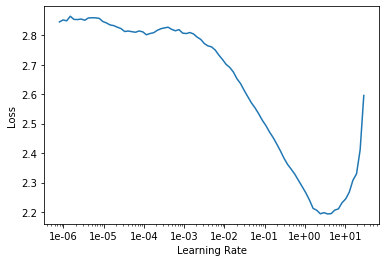

In [0]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

## Implementing the paper



### Issue of computing the simple noise scale

The goal here is to compute the **Simple Noise Scale**, which we recall is the ratio between the sum of the variances of each component of the gradient, over the magnitude of the gradient. Once we have the Simple Noise Scale, we can know which batch size to choose, as it is a good estimator of the optimal batch size in terms of tradeoff computation time/efficiency.

If we denote by $G \in \mathbb{R}^n$ the real gradient of the loss function $\mathcal{L}(\theta,X)$ with respect to $\theta \in \mathbb{R}^n$, then $\mathcal{B}_{simple}$, the Simple Noise Scale, is simply :
$$\mathcal{B}_{simple} = \frac{tr(\Sigma)}{|G|^2} = \frac{\sum_{i=1}^n Var(G_i)}{|G|^2}$$

The problem is, we only have access to the estimate of the gradient, $G_{est} = \frac{1}{B} \sum_{b=1}^B \nabla \mathcal{L}(\theta,X_b)$, with $B$ a given batch size.

So we are facing two problems : 

1.   First, we only have access to the approximative gradient $G_{est}$
2.   Second, we don't have access to $\Sigma = Cov(G)$, the covariance matrix of the real gradient.


The paper proposes two estimators to approximate both $tr(\Sigma)$ and $|G|^2$ :



1.   $$|\mathcal{G}|^2 = \frac{1}{B_{big} - B_{small}} (B_{big} |G_{big}|^2 - B_{small} [G_{small}|^2) \approx |G|^2$$
2.   $$\mathcal{S} = \frac{1}{\frac{1}{B_{small}} - \frac{1}{B_{big}}} (|G_{small}|^2 - |G_{big}|^2 \approx tr(\Sigma)$$

with $B_{big}$, and $B_{small}$ two different batch sizes.

The problem is, the paper assumes we have several GPU devices, and the "small" gradient is computed on a local device, and the "big" gradient is computed on the average gradient between devices. 

As multi-GPU setups are not available for everyone, other strategies have to be adopted for an implementation on single GPU.

I have then tried three different ways to compute the desired quantities $tr(\Sigma)$ and $|G|^2$

### First approach : using exponential moving average

One way to try to solve this problem is to approximate the quantity $\Sigma = Cov(G) = \mathbb{E}[GG^T] - \mathbb{E}[G]\mathbb{E}[G]^T$ 

I have tried the first approximation $G = G_{est}$, i.e. using the observed mini batch gradient.

Then, I have replaced the expectation with a running average accross batches of $G_{est}$ and $|G_{est}|^2$, to compute $tr(\Sigma)$.

In [0]:
from fastai.basic_train import Learner, LearnerCallback

def get_flatten_grad(model):
  """Return the flattened parameter of a model, 
  returns a (n,1) tensor with the total number of parameters"""
  
  parameters = list(model.parameters())
  grads = [param.grad.flatten().view(-1,1) for param in parameters]
  grad = torch.cat(grads)
  return grad

# Linear combination for the moving average
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

def mom3(avg, beta, yi, i):
    "Exponential moving average with debiasing"
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg/(1-beta**(i+1))
  
class BSFinder(LearnerCallback):
  """Callback to use to compute the Simple Noise Scale"""
  
  def __init__(self, learn:Learner, bs=None, num_it:int=100, beta = 0.9):
      super().__init__(learn)
      self.data = learn.data
      if bs: self.data.batch_size = bs
      self.num_it = num_it
      self.beta = beta

  def on_train_begin(self, pbar, **kwargs:Any)->None:
      "Setup the running averages and the output list"

      setattr(pbar, 'clean_on_interrupt', True)
      self.learn.save('tmp')

      # We initialize the running averages
      self.running_theta = None
      self.running_theta_sq = None

      # We create the list which will store the data
      self.output = []

      return {'skip_validate': True}

  def on_backward_end(self, iteration:int, **kwargs:Any)->None:
      "Determine if we did enough iterations"

      if iteration >= self.num_it:
        return {'stop_epoch': True, 'stop_training': True}

      # First we grab the gradient
      model = self.learn.model
      grad = get_flatten_grad(model)

      # We update the gradient, and the squared gradient
      self.running_theta = mom3(self.running_theta,self.beta,grad,iteration)
      self.running_theta_sq = mom3(self.running_theta_sq,self.beta,grad ** 2, iteration)

      # We compute the sum of variances with the formula V[X] = E[X^2] - E[X]^2
      noise = self.running_theta_sq.sum() - (self.running_theta ** 2).sum()

      # We compute the square norm of the gradient
      scale = (grad ** 2).sum()

      # We compute our statistic
      noise_scale = (noise / scale)
      
      self.output.append({"noise":noise.item(),"scale":scale.item(),"noise_scale":noise_scale.item()})

  def on_train_end(self, **kwargs:Any)->None:
      "Cleanup learn model weights disturbed during exploration."
      self.learn.load('tmp', purge=False)
      if hasattr(self.learn.model, 'reset'): self.learn.model.reset()
      for cb in self.callbacks:
          if hasattr(cb, 'reset'): cb.reset()
        


In [0]:
def bs_find(learn:Learner,lr,bs=None, num_it:int=10, beta = 0.9,wd = None):
  cb = BSFinder(learn, bs, num_it, beta)
  epochs = int(np.ceil(num_it/len(learn.data.train_dl)))
  learn.fit(epochs, lr, callbacks=[cb], wd=wd)
  return cb

In [0]:
lr = 1e-1
bs = 64
num_it = 100

cb = bs_find(learn,lr=lr,bs=bs,num_it=num_it)

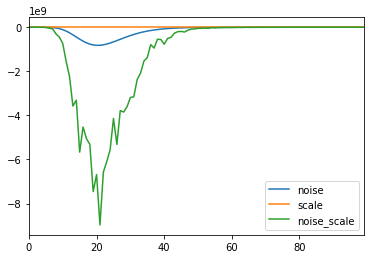

In [0]:
df = pd.DataFrame(cb.output)
df.plot()

Well this does not seem to work at all so I guess we will try to compute it in a different way ...

### Second approach : store every gradient

We saw that using the exponential moving average is not a good idea to approximate the covariance matrix. 

Another way is simply to set in advance a number $N$ of gradients to keep, then we will simply compute $N$ different $G_{est}$, and use those $N$ gradients to approximate the covariance matrix $\Sigma$.

In [0]:
class BSFinder(LearnerCallback):
  """Callback to use to compute the Simple Noise Scale"""
  def __init__(self, learn:Learner, bs=None, num_it:int=10, beta = 0.9):
      super().__init__(learn)
      self.data = learn.data
      if bs: self.data.batch_size = bs
      self.num_it = num_it

  def on_train_begin(self, pbar, **kwargs:Any)->None:
      "Initialize optimizer and learner hyperparameters."
      setattr(pbar, 'clean_on_interrupt', True)
      self.learn.save('tmp')

      self.grads = []

      return {'skip_validate': True}

  def on_backward_end(self, iteration:int, **kwargs:Any)->None:
      
      # We store each mini batch gradient
      model = self.learn.model
      grad = get_flatten_grad(model)
      self.grads.append(grad)

      if iteration >= self.num_it:
        # Once we have stored N gradients we will simply compute our statistic with it
        
        # First we concatenate them
        grads = torch.cat(self.grads,dim=1)
        
        # Then we compute the sum of variances and the scale
        noise = (grads.std(dim = 1) ** 2).sum()
        
        grad = grads.mean(dim = 1)
        scale = (grad ** 2).sum()
        
        self.noise = noise.item()
        self.scale = scale.item()
        self.noise_scale = (noise / scale).item()
        return {'stop_epoch': True, 'stop_training': True}

  def on_train_end(self, **kwargs:Any)->None:
      "Cleanup learn model weights disturbed during exploration."
      self.learn.load('tmp', purge=False)
      if hasattr(self.learn.model, 'reset'): self.learn.model.reset()
      for cb in self.callbacks:
          if hasattr(cb, 'reset'): cb.reset()
        


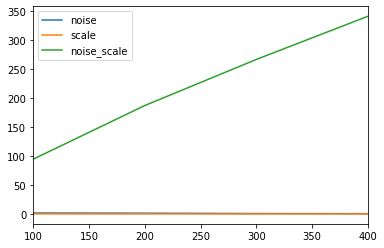

In [0]:
lr = 1e-1
bs = 32

results = []

for num_it in range(100,500,100):
  cb = bs_find(learn,lr,bs,num_it)
  noise,scale,noise_scale = cb.noise, cb.scale, cb.noise_scale
  results.append({"noise":noise,"scale":scale,"noise_scale":noise_scale})
  
df = pd.DataFrame(results)
df.index = list(range(100,500,100))
df.plot()

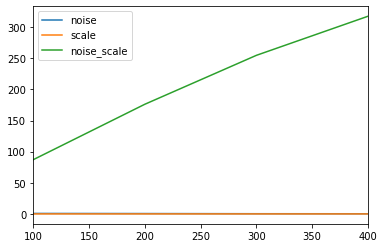

In [0]:
lr = 1e-1
bs = 64

results = []

for num_it in range(100,500,100):
  cb = bs_find(learn,lr,bs,num_it)
  noise,scale,noise_scale = cb.noise, cb.scale, cb.noise_scale
  results.append({"noise":noise,"scale":scale,"noise_scale":noise_scale})
  
df = pd.DataFrame(results)
df.index = list(range(100,500,100))
df.plot()

Ah ! Things seem to work a little bit better, or at least it's not garbage. Nonetheless we do not have the same results as the paper which had a Simple Noise Scale of 50 at the beginning, and 800 at the end.

We see that the batch size does not seem to influence the statistic as is described in the paper.

### Third approach : two batch sizes

As suggested in the paper, we will try using the following formulas : 

1.   $$|\mathcal{G}|^2 = \frac{1}{B_{big} - B_{small}} (B_{big} |G_{big}|^2 - B_{small} [G_{small}|^2) \approx |G|^2$$
2.   $$\mathcal{S} = \frac{1}{\frac{1}{B_{small}} - \frac{1}{B_{big}}} (|G_{small}|^2 - |G_{big}|^2) \approx tr(\Sigma)$$

To do so, we will run two learning cycles, with two different batch sizes, here we use $B_{big} = 2 B_{small}$, keep their respective $|G_{big}|^2$ and $|G_{small}|^2$, and use them to compute $|\mathcal{G}|^2$ and $\mathcal{S}$ in an exponential moving average manner as in described in the paper.

In [0]:
class BSFinder2(LearnerCallback):
    def __init__(self, learn:Learner, bs=None, num_it:int=10, beta = 0.9):
        super().__init__(learn)
        self.data = learn.data
        if bs: self.data.batch_size = bs
        self.num_it = num_it

    def on_train_begin(self, pbar, **kwargs:Any)->None:
        setattr(pbar, 'clean_on_interrupt', True)
        self.learn.save('tmp')
        
        self.grads_sq = []

        return {'skip_validate': True}

    def on_backward_end(self, iteration:int, **kwargs:Any)->None:

        model = self.learn.model
        grad = get_flatten_grad(model)
        
        grad_sq = (grad ** 2).sum()
        self.grads_sq.append(grad_sq)
        
        if iteration >= self.num_it:
          return {'stop_epoch': True, 'stop_training': True}

    def on_train_end(self, **kwargs:Any)->None:
        self.learn.load('tmp', purge=False)
        if hasattr(self.learn.model, 'reset'): self.learn.model.reset()
        for cb in self.callbacks:
            if hasattr(cb, 'reset'): cb.reset()
        


In [0]:
def bs_find2(learn:Learner,lr,bs_min=None,bs_max=None, num_it:int=10, beta = 0.9,wd = None):
  bs_min = bs if bs else learn.data.batch_size
  bs_max = bs_max if bs_max else bs_min * 2
  
  epochs = int(np.ceil(num_it/len(learn.data.train_dl)))
  
  cb_min = BSFinder2(learn, bs_min, num_it, beta)
  learn.fit(epochs, lr, callbacks=[cb_min], wd=wd)
  
  cb_max = BSFinder2(learn, bs_max, num_it, beta)
  learn.fit(epochs, lr, callbacks=[cb_max], wd=wd)
  
  running_noise = None
  running_scale = None
  
  output = []
  
  for i,(g_big,g_small) in enumerate(zip(cb_min.grads_sq,cb_max.grads_sq)):
    noise = (g_small - g_big) / ((1/bs_min) - (1/bs_max))
    scale = (bs_max * g_big - bs_min * g_small) / (bs_max - bs_min)
    
    running_noise = mom3(running_noise,beta,noise,i)
    running_scale = mom3(running_scale,beta,scale,i)
    
    output.append({"noise":running_noise.item(),"scale":running_scale.item(),"noise_scale":(running_noise /running_scale).item()})
  return output

In [0]:
lr = 1e-1
bs = 32
num_it = 200

cb = bs_find2(learn,lr,bs,num_it=num_it)

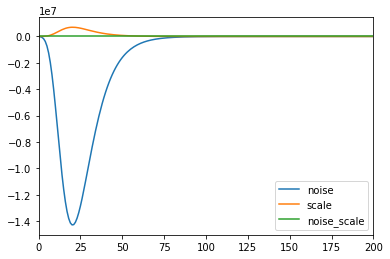

In [0]:
df = pd.DataFrame(cb)
df.plot()

Ok it seems to suck as well. Back to square one I guess !

### Fourth approach : sequential batches

Finally, one way that might have seemed obvious at first, was simply to replace the parallel averaging of gradients, done initially with several GPUs, to a simple sequential averaging of gradients stored in a buffer.



In [0]:
from fastai.basic_train import Learner, LearnerCallback

def get_flatten_grad(model):
  """Return the flattened parameter of a model, 
  returns a (n,1) tensor with the total number of parameters"""
  
  parameters = list(model.parameters())
  grads = [param.grad.flatten().view(-1,1) for param in parameters if not type(param.grad) == type(None)]
  grad = torch.cat(grads)
  return grad

# Linear combination for the moving average
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
  
  
class BSFinder(LearnerCallback):
  
  def __init__(self, learn:Learner, bs=None, num_it:int=None, n_batch = 5,beta = 0.99):
      super().__init__(learn)
      self.data = learn.data
      
      if bs: 
        self.data.batch_size = bs
      else: 
        bs = self.data.batch_size = bs
        
      self.b_small = bs
      self.b_big = bs * n_batch
      
      self.num_it = num_it if num_it else len(self.data.train_ds) // bs
      self.n_batch = n_batch 
      self.beta = beta

  def on_train_begin(self, pbar, **kwargs:Any)->None:
      "Setup the running averages and the output list"

      setattr(pbar, 'clean_on_interrupt', True)
      self.learn.save('tmp')
      
      self.running_scale = None
      self.running_noise = None
      
      self.batches = []

      # We create the list which will store the data
      self.output = []

      return {'skip_validate': True}

  def on_backward_end(self, iteration:int, **kwargs:Any)->None:

      if iteration >= self.num_it:
        return {'stop_epoch': True, 'stop_training': True}

      # First we grab the gradient
      model = self.learn.model
      grad = get_flatten_grad(model)
      self.batches.append(grad)
      
      if iteration % self.n_batch == self.n_batch - 1:
        # We concatenate the batches and empty the buffer

        batches = torch.cat(self.batches,dim = 1)
        self.batches = []
        
        grads = batches.mean(dim = 1)
        
        g_big = (grads ** 2).mean()
        g_small = (grad ** 2).mean()
        
        noise = (self.b_big * g_big - self.b_small * g_small) / (self.b_big - self.b_small)
        scale = (g_small - g_big) / ((1 / self.b_small) - (1 / self.b_big))
        
        self.running_scale, scale = mom3(self.running_scale,self.beta,scale,iteration)
        self.running_noise, noise = mom3(self.running_noise,self.beta,noise,iteration)
        
        scale = scale.item()
        noise = noise.item()
        noise_scale = (scale / noise)
        
        self.output.append({"noise":noise,"scale":scale,"noise_scale":noise_scale})

  def on_train_end(self, **kwargs:Any)->None:
      "Cleanup learn model weights disturbed during exploration."
      self.learn.load('tmp', purge=False)
      if hasattr(self.learn.model, 'reset'): self.learn.model.reset()
      for cb in self.callbacks:
          if hasattr(cb, 'reset'): cb.reset()
  
  def plot(self):
    df = pd.DataFrame(self.output)
    df.noise_scale.plot(title=f"Average Noise scale : {df.noise_scale.mean()}")

In [0]:
def bs_find(learn:Learner,lr,bs=None, num_it:int=None, n_batch = 20,beta = 0.99,wd = None):
  if not bs: bs = learn.data.batch_size
  if not num_it : num_it = len(learn.data.train_ds) // bs
    
  cb = BSFinder(learn, bs=bs, num_it=num_it, n_batch=n_batch,beta=beta)
  epochs = int(np.ceil(num_it/len(learn.data.train_dl)))
  learn.fit(epochs, lr, callbacks=[cb], wd=wd)
  
  return cb

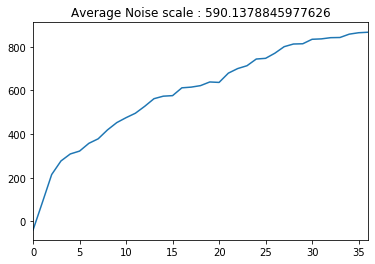

In [12]:
# We create our learner
model = create_model()
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

lr = 0.05
bs = 64
num_it = 750
n_batch = 20
beta = 0.99

bs_find(learn,lr=lr,bs=bs,num_it=num_it,n_batch=n_batch,beta=beta).plot()

In [0]:
bs = 32
lr = 0.05
n_epoch = 12

model = create_model()
# We create our learner

learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.data.batch_size = bs
learn.fit_one_cycle(n_epoch,lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.261281,0.216324,0.937417,01:01
1,0.166257,0.465717,0.858167,01:01
2,0.136244,0.103858,0.968500,01:02
3,0.141328,0.092951,0.972000,01:02
4,0.129287,0.164577,0.951167,01:02
5,0.103201,0.187019,0.943167,01:02
6,0.101905,0.053372,0.985500,01:02
7,0.083407,0.522800,0.984167,01:02
8,0.052406,0.043899,0.988583,01:02
9,0.043776,0.026141,0.991500,01:01


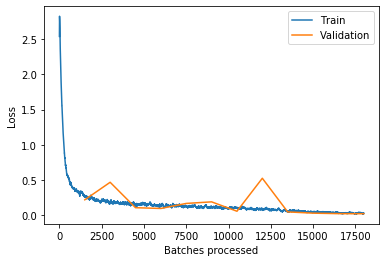

In [0]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


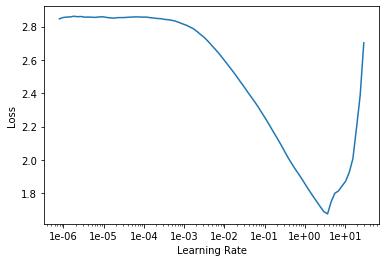

In [0]:
bs = 512
lr = 0.05
n_epoch = 18

model = create_model()
# We create our learner
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.data.batch_size = bs

learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(n_epoch,1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.609383,0.245341,0.946833,00:28
1,0.218782,0.117915,0.965667,00:28
2,0.129089,0.265005,0.923583,00:28
3,0.102456,0.303500,0.906833,00:28
4,0.086146,0.114640,0.966333,00:28
5,0.076784,0.082325,0.975083,00:28
6,0.067621,0.121937,0.963750,00:28
7,0.067483,0.152722,0.950250,00:28
8,0.054785,0.140717,0.960500,00:28
9,0.050790,0.040508,0.986500,00:27


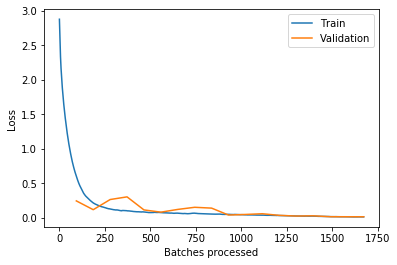

In [0]:
learn.recorder.plot_losses()

## Further testing

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### IMDB



In [0]:
from fastai.text import * 

input_path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(input_path/'texts.csv')

output_path = Path("/content/drive/My Drive/imdb/")

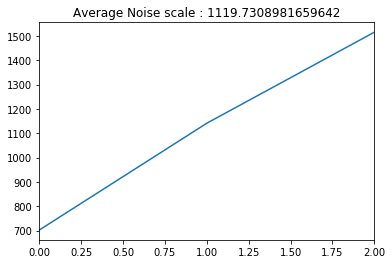

In [0]:
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv',bs=64)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

lr = 1e-2
beta = 0.99
num_it = 60
n_batch = 10

cb = bs_find(learn,lr=lr,bs=bs,beta=beta,num_it=num_it)
cb.plot()

#### Batch size 256

In [0]:
bs = 256

In [0]:
data_lm = TextLMDataBunch.from_csv(input_path, 'texts.csv',bs=bs)
data_clas = TextClasDataBunch.from_csv(input_path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=bs)

data_lm.save(output_path/'data_lm_export.pkl')
data_clas.save(output_path/'data_clas_export.pkl')

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.382652,4.014507,0.269210,00:18


In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.098351,3.912468,0.286161,00:22


In [0]:
learn.predict("This is a review about", n_words=10)

'This is a review about the history of the types of party before the new'

In [0]:
learn.save_encoder(output_path/'ft_enc')

In [0]:
# Classifier model data
data_clas = load_data(output_path, 'data_clas_export.pkl', bs=bs)

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(output_path/'ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (799 items)
x: TextList
xxbos xxmaj beautiful and touching movie . xxmaj rich colors , great settings , good acting and one of the most charming movies i have seen in a while . i never saw such an interesting setting when i was in xxmaj china . xxmaj my wife liked it so much she asked me to xxunk on and rate it so other would enjoy too .,xxbos i watched , xxunk and xxunk , by the xxunk and physical acting . xxmaj the roles each character played were done with excellence . xxmaj the lyrics , the words , every gesture , the sunrise , told it all . xxmaj the movie xxunk to me . xxmaj it xxunk me to a different perception of a person who believes in mankind . xxmaj who believes in peace and gentle behavior . i was also held in xxunk , by the sacrifices and human dignity was portrayed . xxmaj power without grace , is demented and without feelings . xxmaj to want power at the cost of mankind , is so unbelievable . xxmaj this movie made me 

In [0]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8880, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8880, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, ep

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

#### Batch size 64

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.data.batch_size = 32
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.225012,3.830161,0.295354,00:37


### Planet competition

We will know try this heuristic with a real world data set that was explored in Fastai course v3 : the planet dataset.

In [0]:
!pip install kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space

 98% 589M/600M [00:10<00:00, 106MB/s]
100% 600M/600M [00:10<00:00, 61.9MB/s]
 99% 599M/603M [00:13<00:00, 27.0MB/s]
100% 603M/603M [00:14<00:00, 44.3MB/s]
100% 12.9G/12.9G [05:56<00:00, 45.1MB/s]
100% 12.9G/12.9G [05:56<00:00, 38.8MB/s]
100% 19.4G/19.4G [08:22<00:00, 40.9MB/s]
100% 19.4G/19.4G [08:22<00:00, 41.6MB/s]
 98% 297M/304M [00:08<00:00, 50.3MB/s]
100% 304M/304M [00:09<00:00, 35.3MB/s]
  0% 0.00/1.52M [00:00<?, ?B/s]
100% 1.52M/1.52M [00:00<00:00, 102MB/s]
  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 141MB/s]
  0% 0.00/154k [00:00<?, ?B/s]
100% 154k/154k [00:00<00:00, 149MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 70.7MB/s]
  0% 0.00/110k [00:00<?, ?B/s]
100% 110k/110k [00:00<00:00, 97.7MB/s]


In [0]:
!unzip -q -n train_v2.csv.zip

In [0]:
df = pd.read_csv('train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
!sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [0]:
!7z x -so train-jpg.tar.7z | tar xf - -C target_dir

tar: target_dir: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [0]:
!7za x train-jpg.tar.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 629296207 bytes (601 MiB)

Extracting archive: train-jpg.tar.7z
--
Path = train-jpg.tar.7z
Type = 7z
Physical Size = 629296207
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train-jpg.tar                      1% - train-jpg.tar                      2% - train-jpg.tar                      3% - train-jpg.tar                      4% - train-jpg.tar                      5% - train-jpg.tar                      6% - train-jpg.tar

In [0]:
from fastai.vision import *

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
path = Path()
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

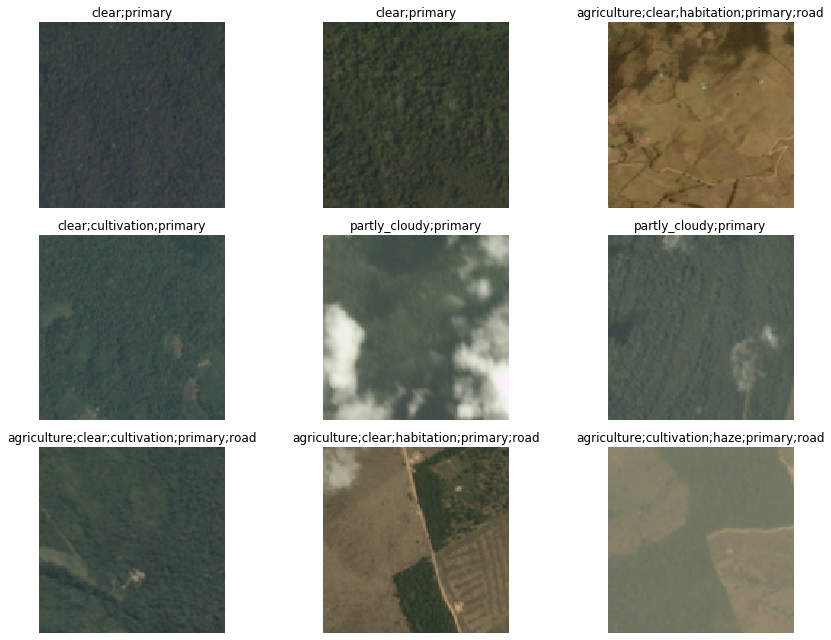

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


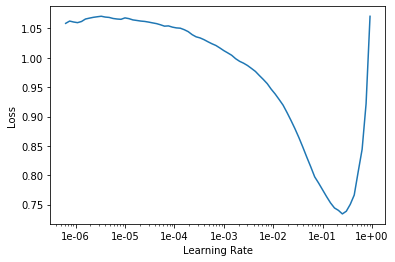

In [0]:
learn.recorder.plot()

In [0]:
lr = 1e-1

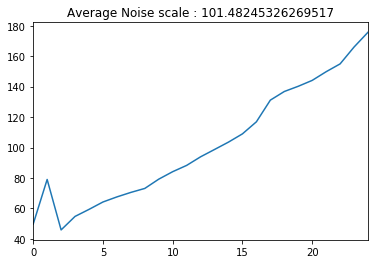

In [0]:
num_it = 500
n_batch = 20
beta = 0.999
bs = 64

cb = bs_find(learn,lr,bs,num_it,n_batch,beta)

df = pd.DataFrame(cb.output)
df.noise_scale.plot(title=f"Average Noise scale : {df.noise_scale.mean()}")

#### Batch size 256

In [0]:
learn.data.batch_size = 256

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.162003,0.109974,0.939999,0.905722,03:55
1,0.118477,0.110114,0.942579,0.907522,03:41
2,0.109199,0.099562,0.953588,0.912283,03:40
3,0.098310,0.088738,0.959946,0.923327,03:42
4,0.088556,0.084753,0.957519,0.926949,03:40


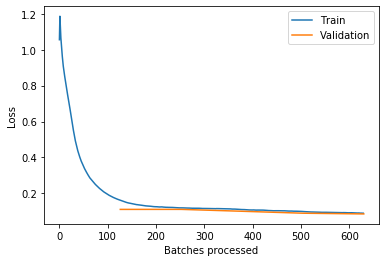

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save("/content/drive/My Drive/stage1_bs-512")

In [0]:
learn.load("/content/drive/My Drive/stage1_bs-512")

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: .;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


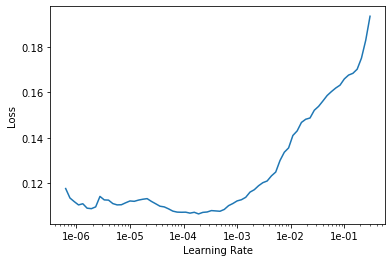

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.data.batch_size = 256
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


RuntimeError: ignored

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save("/content/drive/My Drive/stage2_bs-512")

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.data.batch_size = 256

64

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

#### Batch size 64

In [0]:
learn.data.batch_size = 64
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.157197,0.125118,0.944345,0.886986,03:53
1,0.178757,1.602167,0.945631,0.853175,03:44
2,0.146844,2.553673,0.942041,0.891681,03:42
3,0.114103,0.191497,0.952578,0.912775,03:44
4,0.096714,0.215476,0.954445,0.919447,03:44


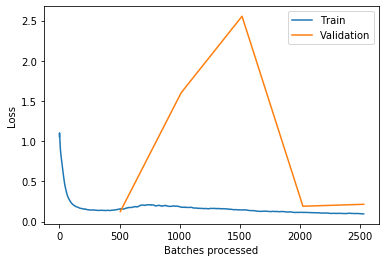

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save("/content/drive/My Drive/stage1_bs-64")

### Rossman store

In [0]:
from fastai.tabular import *

In [0]:
path = Path("/content/drive/My Drive/rossmann")

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [0]:
procs=[FillMissing, Categorify, Normalize]

cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [0]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
valid_idx = range(cut)

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

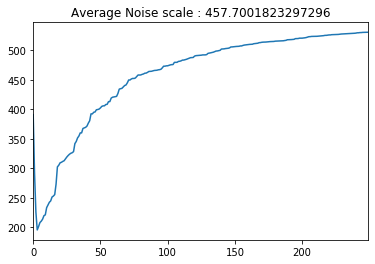

In [48]:
lr = 1e-3
bs = 64
beta = 0.999
wd = 0.2
num_it = 5000
n_batch = 20

bs_find(learn,lr=lr,num_it=num_it,n_batch=n_batch,bs=bs,beta=beta,wd=wd).plot()

#### Batch 512

In [0]:
bs = 512
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [50]:
learn.data.batch_size = bs
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.064203,0.081175,0.336949,01:16
1,0.017967,0.022648,0.158436,01:15
2,0.012540,0.016045,0.134239,01:15
3,0.010017,0.013109,0.114945,01:15
4,0.008628,0.012873,0.115121,01:16


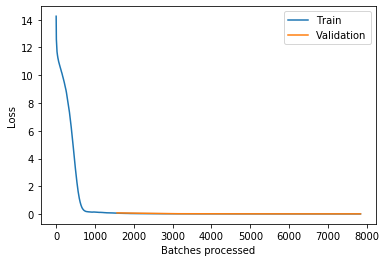

In [51]:
learn.recorder.plot_losses()

In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time


In [0]:
learn.recorder.plot_losses()

In [0]:
learn.fit_one_cycle(5, 3e-4)

In [0]:
learn.recorder.plot_losses()

#### Batch 64

In [0]:
bs = 64
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [0]:
learn.data.batch_size = bs
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.025600,0.025420,0.170128,04:11
1,0.019492,0.019629,0.146882,04:12
2,0.015665,0.016579,0.129733,04:12
3,0.014234,0.012524,0.106481,04:17
4,0.011758,0.010876,0.101445,04:17


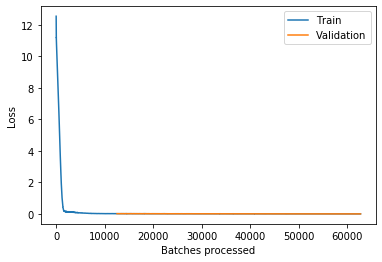

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012296,0.017129,0.115411,04:12
1,0.013106,0.019733,0.111697,04:11
2,0.011296,0.015144,0.114529,04:11
3,0.009617,0.015935,0.112019,04:11
4,0.008971,0.016903,0.116226,04:12


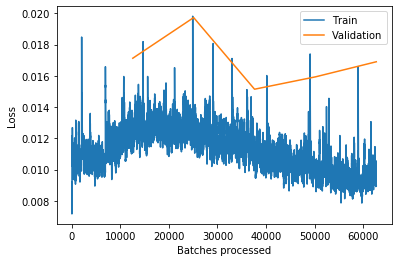

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010284,0.015692,0.119779,04:12
1,0.012072,0.016226,0.127236,04:11
2,0.010314,0.044199,0.119382,04:10
3,0.009456,0.020770,0.114096,04:11
4,0.010367,0.013624,0.113684,04:12


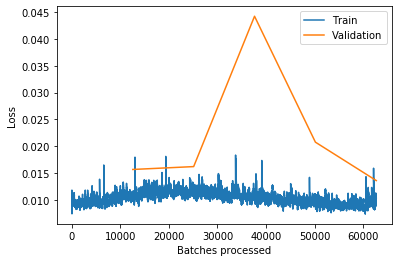

In [0]:
learn.recorder.plot_losses()